In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
import argparse
import matplotlib

from tqdm import tqdm
import glob
from PIL import Image
import os
from datetime import datetime
import time
import math
from torch.autograd import Variable
from biotorch.module.biomodule import BioModule

from ANN import *
from visualization import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.FashionMNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.FashionMNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
device = "cuda"
criterion = torch.nn.MSELoss().to(device)
# criterion = torch.nn.CrossEntropyLoss()
activation = F.relu
architecture = [784, 500, 10]
model = BioModule(MLP(architecture, activation = activation, final_layer_activation = None), mode = "fa").to(device)
model

Module has been converted to fa mode:

The layer configuration was:  {'type': 'fa', 'options': {'constrain_weights': False, 'gradient_clip': False, 'init': 'xavier'}}
- All the 2 <class 'torch.nn.modules.linear.Linear'> layers were converted successfully.


BioModule(
  (module): MLP(
    (linear_layers): ModuleList(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): Linear(in_features=500, out_features=10, bias=True)
    )
  )
)

In [5]:
model

BioModule(
  (module): MLP(
    (linear_layers): ModuleList(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): Linear(in_features=500, out_features=10, bias=True)
    )
  )
)

In [6]:
evaluateClassification(model, train_loader, "cuda")

Accuracy :	 0.04665


0.04665

In [7]:
# # specify optimizer (stochastic gradient descent) and learning rate
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.001, nesterov=True)

lr_decay_step = 50
lr_decay = 0.9
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay)
trn_acc_list = []
tst_acc_list = []

n_epochs = 20
for epoch_ in range(n_epochs):
    model.train()
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = Variable(x.to(device)), Variable(y.to(device))
        y_one_hot = F.one_hot(y, num_classes=10)
        optimizer.zero_grad()
        y_hat = model(x)
#         loss = criterion(y_hat,y) # Use this if criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(y_hat,y_one_hot.to(torch.float32)) # Use this if criterion = torch.nn.MSELoss().to(device)
        # backward pass: compute gradient of the loss with respect to model parameters
#         model.zero_grad()
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
    
    scheduler.step()
    trn_acc = evaluateClassification(model, train_loader, device, False)
    tst_acc = evaluateClassification(model, test_loader, device, False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [00:22, 134.60it/s]
14it [00:00, 137.54it/s]

Epoch : 1, Train Accuracy : 0.8215666666666667, Test Accuracy : 0.8069


3000it [00:26, 112.71it/s]
12it [00:00, 114.21it/s]

Epoch : 2, Train Accuracy : 0.87505, Test Accuracy : 0.8595


3000it [00:32, 91.81it/s] 
9it [00:00, 85.65it/s]

Epoch : 3, Train Accuracy : 0.8770833333333333, Test Accuracy : 0.859


3000it [00:33, 90.78it/s]
10it [00:00, 88.63it/s]

Epoch : 4, Train Accuracy : 0.8679166666666667, Test Accuracy : 0.8466


3000it [00:33, 90.15it/s]
9it [00:00, 84.38it/s]

Epoch : 5, Train Accuracy : 0.8922, Test Accuracy : 0.8706


3000it [00:33, 89.56it/s]
8it [00:00, 79.18it/s]

Epoch : 6, Train Accuracy : 0.8956, Test Accuracy : 0.8734


3000it [00:33, 88.57it/s]
8it [00:00, 79.56it/s]

Epoch : 7, Train Accuracy : 0.9007666666666667, Test Accuracy : 0.8794


3000it [00:35, 85.02it/s]
9it [00:00, 86.28it/s]

Epoch : 8, Train Accuracy : 0.9046166666666666, Test Accuracy : 0.8816


3000it [00:34, 88.03it/s]
8it [00:00, 72.16it/s]

Epoch : 9, Train Accuracy : 0.9045666666666666, Test Accuracy : 0.88


3000it [00:35, 84.68it/s]
13it [00:00, 126.11it/s]

Epoch : 10, Train Accuracy : 0.89995, Test Accuracy : 0.8701


3000it [00:21, 138.22it/s]
13it [00:00, 124.69it/s]

Epoch : 11, Train Accuracy : 0.9086333333333333, Test Accuracy : 0.8803


3000it [00:21, 137.11it/s]
8it [00:00, 77.16it/s]

Epoch : 12, Train Accuracy : 0.9097166666666666, Test Accuracy : 0.8794


3000it [00:33, 89.62it/s]
9it [00:00, 80.67it/s]

Epoch : 13, Train Accuracy : 0.9079, Test Accuracy : 0.874


3000it [00:33, 89.45it/s]
4it [00:00, 39.55it/s]

Epoch : 14, Train Accuracy : 0.9033333333333333, Test Accuracy : 0.8753


3000it [00:35, 85.63it/s]
4it [00:00, 37.88it/s]

Epoch : 15, Train Accuracy : 0.8994833333333333, Test Accuracy : 0.8676


3000it [00:46, 64.60it/s]
6it [00:00, 57.44it/s]

Epoch : 16, Train Accuracy : 0.9111166666666667, Test Accuracy : 0.8788


3000it [00:49, 60.96it/s]
6it [00:00, 55.85it/s]

Epoch : 17, Train Accuracy : 0.9073333333333333, Test Accuracy : 0.8738


3000it [00:47, 63.41it/s]
7it [00:00, 59.10it/s]

Epoch : 18, Train Accuracy : 0.9151166666666667, Test Accuracy : 0.8796


3000it [00:46, 64.52it/s]
7it [00:00, 58.85it/s]

Epoch : 19, Train Accuracy : 0.9235, Test Accuracy : 0.8858


3000it [00:46, 64.94it/s]


Epoch : 20, Train Accuracy : 0.9233, Test Accuracy : 0.8858


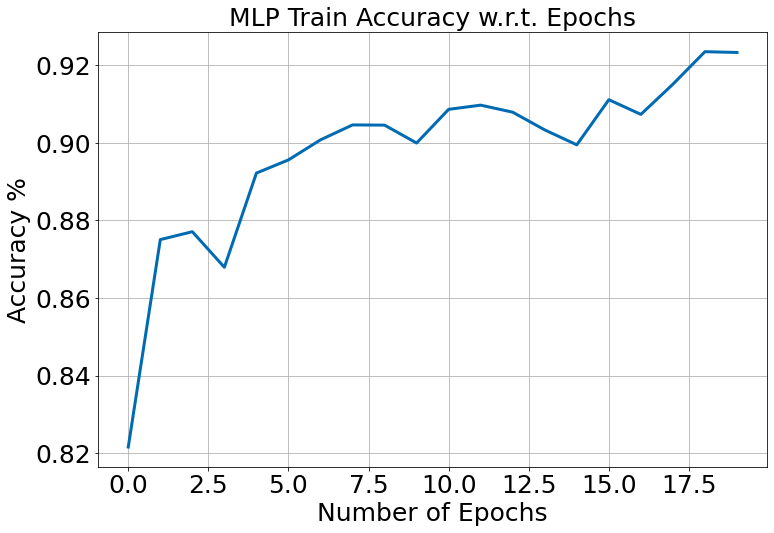

In [8]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'MLP Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

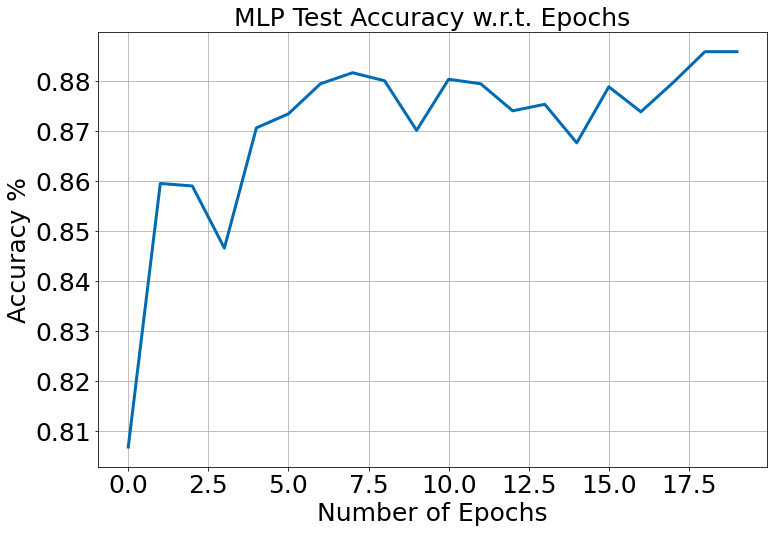

In [9]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'MLP Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)